In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import sparse
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from tqdm.notebook import trange, tqdm
from scipy.sparse import save_npz, load_npz
import scipy

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import os
import tensorflow as tf
sns.set()

### And from this spot we start!

### Here we go! @fabriziorom (Who knows - he gets)

In [93]:
train_data = sparse.load_npz("train.npz")
#test_data = pd.read_csv('sample_submission.csv')

In [94]:
train_data = pd.DataFrame(train_data.toarray()).astype('float16')

In [95]:
train_data.shape

(14590, 77888)

In [5]:
means = train_data.mean()

Text(0.5, 0, 'Mean value, $X_{mean}$')

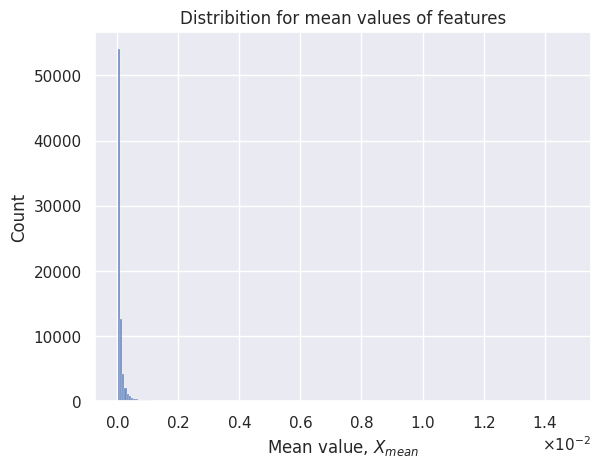

In [6]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = train_data.mean(), bins = 200)

plt.title('Distribition for mean values of features')
plt.xlabel('Mean value, $X_{mean}$')

In [7]:
print(means.quantile(0.9))

0.0002181529998779297


In [8]:
print(means.max() - means.min())
print(means.max())
print(means.min())

0.01476
0.01478
1.407e-05


### Here I calculated the mean distance and diameter of set.

In [9]:
# Diameter

centroid = np.mean(train_data, axis = 0)
distances = np.linalg.norm(train_data - centroid, axis = 1)

In [10]:
diameter = np.max(distances)

In [11]:
print(diameter)

1.006


In [12]:
# Average distance

mean_distance = np.mean(distances)

In [13]:
print(mean_distance)

0.9927


### We may notice that diameter and average distance are same order values, so probably the set is compact.

### Then, I googled for Gini coefficient to realize the level of heterogeneity for different features.

In [96]:
# Gini Coefficient

gini_coefficients = train_data.apply(lambda x: 1 - 2*np.trapz(np.cumsum(np.sort(x))/
                                                              np.sum(x),
                                                              np.arange(1, len(x) + 1) /
                                                              len(x)))

print(gini_coefficients)

0        0.999556
1        0.998275
2        0.999002
3        0.999445
4        0.999058
           ...   
77883    0.999589
77884    0.999707
77885    0.999083
77886    0.999272
77887    0.999659
Length: 77888, dtype: float64


In [97]:
print(gini_coefficients.mean())
print(gini_coefficients.min())
print(gini_coefficients.max())

0.9986480811258722
0.6812089778283754
0.9998379723677658


### Let's plot the distribution

(0.95, 1.0)

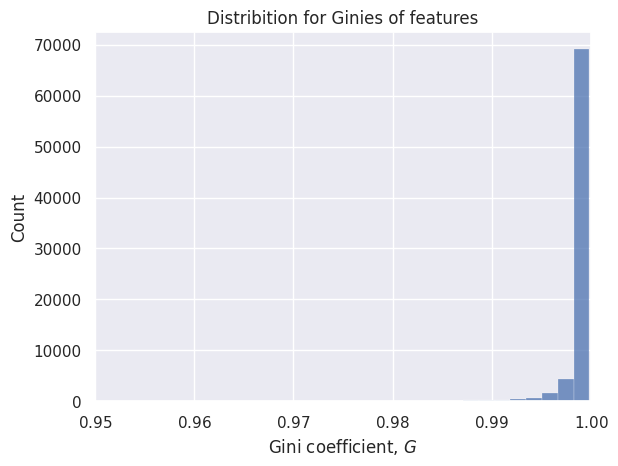

In [98]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = gini_coefficients, bins = 200)

plt.title('Distribition for Ginies of features')
plt.xlabel(f'Gini coefficient, $G$')
plt.xlim([0.95, 1.0])

### But otherwise the Gini coefficient reveals us that a lot of featrures intent to the 1 value. That means the opposite to compact properties. So, we may filter by Gini.

In [99]:
print(gini_coefficients.quantile(0.01))

0.984457040479528


In [100]:
threshold_gini = gini_coefficients.quantile(0.01)

In [101]:
def columns_low_gini(gini):
    count = []
    for i in range(len(gini)):

        if gini.values[i] <= threshold_gini:
            count.append(i)
    return count

count_gini = columns_low_gini(gini_coefficients)

In [102]:
print(len(count_gini))

779


In [103]:
train_data = train_data.drop(columns = count_gini).astype('float16')

### Right there we dropped 779 columns. That's good for start.

In [106]:
print(train_data.shape)

(14590, 77109)


In [105]:
train_data = train_data.T.reset_index(drop=True).T

### Next try to detect the percentage of zero values for different columns

In [108]:
percentage_nonzero = np.count_nonzero(train_data, axis = 0) / train_data.shape[0]
print(percentage_nonzero)
print(percentage_nonzero.shape)

[0.00061686 0.00233036 0.00123372 ... 0.00123372 0.00089102 0.00047978]
(77109,)


In [109]:
percentage_nonzero

array([0.00061686, 0.00233036, 0.00123372, ..., 0.00123372, 0.00089102,
       0.00047978])

### Plot the distribution

(0.0, 0.5)

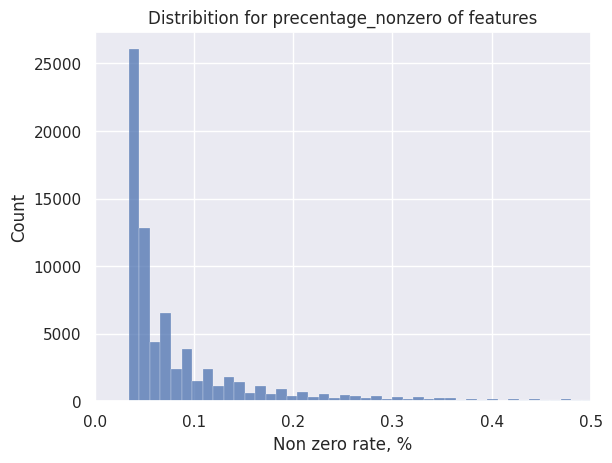

In [111]:
sns.histplot(data = percentage_nonzero*100, bins = 200)

plt.title('Distribition for precentage_nonzero of features')
plt.xlabel(f'Non zero rate, %')
plt.xlim([0, 0.5])

In [112]:
print(percentage_nonzero.max())
print(percentage_nonzero.min())
print(percentage_nonzero.mean())
serie = pd.Series(data = percentage_nonzero)
print(serie.quantile(0.10))
threshold_nonzero = serie.quantile(0.1)

0.021590130226182315
0.0003427004797806717
0.0012087177341713947
0.0003427004797806717


In [113]:
def columns_low_percentage(non_zero):
    count = []
    for i in range(train_data.shape[1]):

        if non_zero[i] <= threshold_nonzero:
            count.append(i)
    return count

count_nonzero = columns_low_percentage(serie)

In [114]:
len(count_nonzero)

15522

In [115]:
train_data = train_data.drop(columns = count_nonzero).astype('float16')

### Here we dropped the less non_zero rate values and ~15k features with them. Step by step we're filtering the features.

In [116]:
train_data.shape

(14590, 61587)

In [117]:
train_data = train_data.T.reset_index(drop=True).T

### Let's check on the stddev in different features

In [118]:
stddev_array = np.zeros((train_data.shape[1]))

In [120]:
def sttdev_count(sttdev_array, data):
    for i in range(data.shape[1]):
        sttdev_array[i] = data.iloc[:, i].std()
    return sttdev_array

stddev_array = sttdev_count(stddev_array, train_data)


In [121]:
stddev_array, len(stddev_array)

(array([0.00385284, 0.00556564, 0.00253677, ..., 0.00341797, 0.00413513,
        0.00335693]),
 61587)

In [122]:
sttdev_array_series = pd.Series(data=stddev_array)

### And build the histplot

Text(0.5, 0, 'Standard deviation, $\\sigma$')

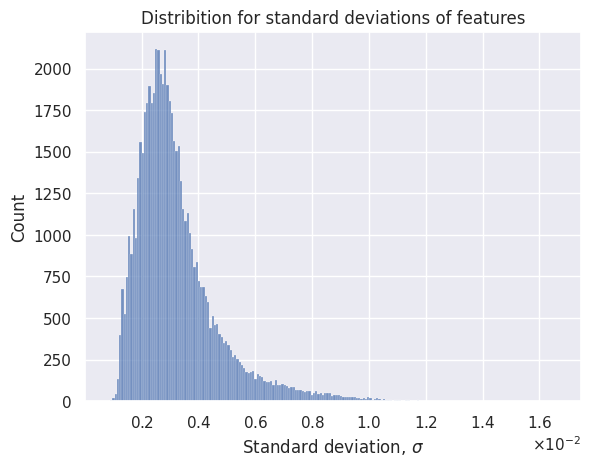

In [123]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = stddev_array, bins = 200)

plt.title('Distribition for standard deviations of features')
plt.xlabel(f'Standard deviation, $\sigma$')

### As we notice, distribution looks like Gaussian. Let's try to calc quantile values

In [126]:
print(sttdev_array_series.quantile(0.25))
print(sttdev_array_series.quantile(0.999))

0.002277374267578125
0.010948715209961102


In [127]:
threshold_percent_quantile = sttdev_array_series.quantile(0.25)
nn_percent_quantile = sttdev_array_series.quantile(0.99)

In [128]:
threshold_percent_quantile

0.002277374267578125

### We assume low std_dev value to be noise features. Let's denote that the phenomenon of low std_dev corresponds to the all objects having similar feature, smth like narrow gaussian that shows the low variance of data corresponding to this feature. So, I try to make this pre-filtering.

Otherwise, my office laptop with 4 Gb RAM shall die

In [129]:
def drop_low_stddev_columns(data):
    count = []
    for i in range(data.shape[1]):
        if stddev_array[i] <= threshold_percent_quantile:
            count.append(i)
    return count

count = drop_low_stddev_columns(train_data)

In [130]:
len(count)

15446

### I assume to save only the features with the highest variance. Otherwise I'll always dive into memory allocation problem by the way. My goal is to maximally decrease the size of feature space.

In [131]:
stay_features = train_data.shape[1] - len(count)
print(stay_features)

46141


In [132]:
train_data = train_data.drop(columns = count).astype('float16')

In [133]:
train_data.shape

(14590, 46141)

### We got the 46141 features right now. So, probably it helps...

In [2]:
import psutil
print(f"Memory: {psutil.Process().memory_info().rss / 1024**2:.2f} Mb")

Memory: 341.59 Mb


In [140]:
np.save("my_matrix.npy", train_data.to_numpy())

In [142]:
np.savez("filtered_matrix.npz", train_data.to_numpy())

In [3]:
from scipy.sparse import save_npz, load_npz
import scipy

In [148]:
x_csr = scipy.sparse.csr_matrix(train_data)

In [150]:
x_csc = scipy.sparse.csc_matrix(train_data)

In [ ]:
print(x_csc)

In [ ]:
print(x_csr)

In [153]:
save_npz('sparsed_filtered_matrix.npz', x_csr)

In [154]:
loaded_matrix = load_npz('sparsed_filtered_matrix.npz').toarray()

In [155]:
loaded_matrix.shape

(14590, 46141)

### So, the low-level filtering gave us ~9k less features than it was initial, why not?

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [159]:
import shutil
shutil.move('sparsed_filtered_matrix.npz', '/content/drive/My Drive/')


'/content/drive/My Drive/sparsed_filtered_matrix.npz'

### Go on

In [96]:
train_data = sparse.load_npz('sparsed_filtered_matrix.npz')

In [97]:
train_data = pd.DataFrame(train_data.toarray()).astype('float16')

In [98]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14590 entries, 0 to 14589
Columns: 46141 entries, 0 to 46140
dtypes: float16(46141)
memory usage: 1.3 GB


In [99]:
train_data.shape

(14590, 46141)

In [100]:
import psutil
print(f"Memory: {psutil.Process().memory_info().rss / 1024**2:.2f} Mb")

Memory: 1674.54 Mb


### I try to calc correlation matrix to figure out the connections between features. I assume correlated features to be generated from the same space, probably

In [69]:
train_data = pd.DataFrame(train_data).sample(frac = 1)
train_data.reset_index(drop = True, inplace = True)
train_data.iloc[:, :1000]

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
a = np.corrcoef(train_data.iloc[:, :1000], rowvar=False)
a.shape

(1000, 1000)

In [ ]:
a.diagonal() # Checking for true values on diagonal

In [ ]:
def mutual_correlations(data):
    correlations_array = []
    for i in range(data.shape[0]):
        for j in range(i+1, data.shape[1]):
            if data[i][j] > 0.8:
                print(i, j)
            correlations_array.append(data[i][j])
    return correlations_array
    
            
correlation_array_test = mutual_correlations(a)

In [126]:
len(correlation_array_test)

499500

In [127]:
max(correlation_array_test)

1.0

In [128]:
correlation_array_test[:10]

[-0.0009717450283949869,
 -0.0007370978317736803,
 0.02490204220832917,
 -0.0010443666971854959,
 -0.000421109887296796,
 -0.0006180554112328895,
 -0.0016361991150269813,
 -0.0006629045154278487,
 -0.00043092212197222337,
 -0.0004384355445690983]

(0.0, 200.0)

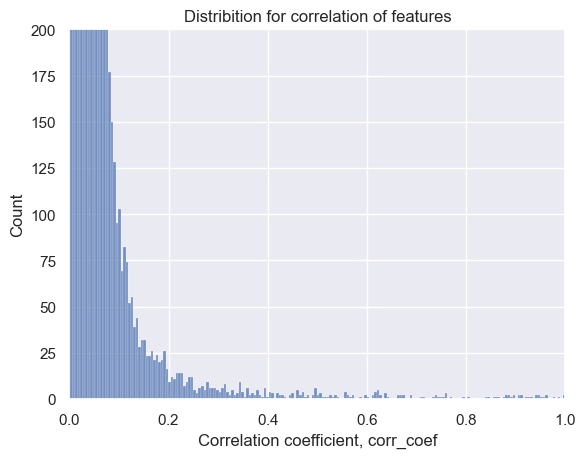

In [129]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 7))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = correlation_array_test, bins = 200)

plt.title('Distribition for correlation of features')
plt.xlabel(f'Correlation coefficient, corr_coef')
plt.xlim([0, 1])
plt.ylim([0, 200])

### Notice, correlation distribution is high on some features. So, probably we may filter them making new features. Let the threshold be 0.55, Why not? 

In [132]:
a.shape

(1000, 1000)

In [317]:
corr_cols = []
template = train_data.iloc[:, :1000]
corr_matrix = template.corr()

def corr_matrix_cols(corr_matrix):
    corr_cols = []
    for i in range(len(corr_matrix.columns)):
        cols = set()
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.6:
                cols.add(i)
                cols.add(j)
                
        corr_cols.append(cols)
    return corr_cols
    

# for cols in corr_cols:
#     mean_col = template[template.columns[cols]].mean(axis = 1, inplace = True)
#     template['mean' + '_'.join(template.columns[corr_matrix])] = mean_col


In [211]:
train_data.iloc[:, :1000].shape

(14590, 1000)

In [212]:
template.shape

(14590, 1000)

In [213]:
corr_matrix.shape

(1000, 1000)

In [319]:
corr_cols = [set for set in corr_cols if len(set) != 0]

In [398]:
corr_cols[30:40]

[{222, 223},
 {225, 226},
 {248, 249},
 {281, 282},
 {292, 293},
 {308, 310, 311},
 {310, 311},
 {335, 336},
 {337, 338},
 {414, 415}]

In [414]:
some = template.copy()

In [415]:
def drop_correlated_columns(some, corr_cols):
    some_tmp = some
    for i, cols in enumerate(corr_cols):
        # print(cols)
        mean_col = some_tmp[some_tmp.columns[list(cols)]].mean(axis = 1)
        some_tmp['mean' + '_'.join(some_tmp.columns[list(cols)].astype(str))] = mean_col
        # if i == 3:
        #     break
        # print(mean_col)
    print(some_tmp.shape)
    tmp_set = set()
    for i, cols in enumerate(corr_cols):
        count = 0
        for element in cols:
            if element not in tmp_set:
                count += 1
                some_tmp.drop(columns = [element], inplace = True)
            tmp_set.add(element)
            
        if count != len(cols):
             print(cols)
             some_tmp.drop(columns = ['mean' + '_'.join([str(elem) for elem in cols])], inplace = True)
    print(some_tmp.shape)
    return some_tmp
    

some = drop_correlated_columns(some, corr_cols)      

(14590, 1068)
{148, 149}
{153, 154}
{157, 158}
{161, 162}
{310, 311}
(14590, 932)


In [416]:
some.shape

(14590, 932)

In [418]:
some.iloc[:, 880:].head()

,mean124_125,mean139_140,mean142_143,mean144_146,mean147_148_149,mean150_151,mean152_153_154,mean155_157,mean161_162_159,mean171_172,...,mean692_693,mean694_695,mean699_700,mean720_719,mean741_742,mean769_770,mean834_835,mean900_901,mean933_934,mean958_959
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054749,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053345,0.0,0.0


In [420]:
def corr_matrix_cols(corr_matrix): # Corr_cols func
    corr_cols = []
    for i in range(len(corr_matrix.columns)):
        cols = set()
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.6:
                cols.add(i)
                cols.add(j)
                
        corr_cols.append(cols)
    return corr_cols

### So lucky. Next I should got through the batches of features and clean correlated. I do with the batch_size, because having 41000 x 41000 np.corrcoef marix will probably kill my laptop

In [424]:
feature_batch_size = 1000
new_train_data = pd.DataFrame()
for i in tqdm(range(5000, train_data.shape[1], 5000)):
    some = train_data.iloc[:, :i]
    corr_matrix = some.corr()
    columns = corr_matrix_cols(corr_matrix)
    some_new = drop_correlated_columns(some, columns)
    new_train_data = pd.concat([new_train_data, some_new])
    print(i)

### Failed as the time delay. Ok, I got that this approach probably works and we gotta go (may be) come back later.

In [7]:
train_data.shape

(14590, 46141)

In [101]:
import psutil
print(f"Memory: {psutil.Process().memory_info().rss / 1024**2:.2f} Mb")

Memory: 1673.36 Mb


### I'm going to test mean_absolute_distance (MAD) rate:

$MAD_{i} = \frac{1}{n} \displaystyle\sum_{j = 1} ^{n} |X_{ij} - \overline{X}_{i} |$,

Where $\overline{X}_{i}$ - mean value of corresponding on $i$-th feature,
# 
$X_{ij}$ - value of $i$-th feature on $j$-th object,
#
$n$ - dataset's length.


In [102]:
mean_absolute_distance = np.sum(np.abs(train_data - np.mean(train_data, axis = 0)), axis = 0) / train_data.shape[0]

In [103]:
mean_absolute_distance.shape

(46141,)

Text(0.5, 0, 'Mean Absolute Distance, $MAD$')

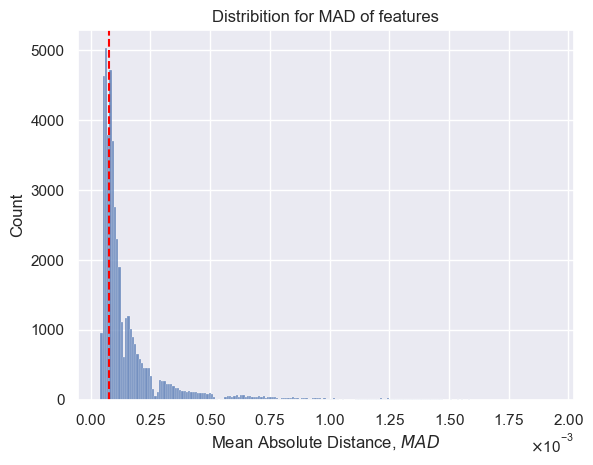

In [104]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = mean_absolute_distance, bins = 200)
plt.axvline(mean_absolute_distance.quantile(0.32), linestyle = 'dashed', color = 'red')

plt.title('Distribition for MAD of features')
plt.xlabel(f'Mean Absolute Distance, $MAD$')

### I assume that the more $MAD$-value the more informative feature is...

In [105]:
print(mean_absolute_distance.quantile(0.32))

7.858014578232542e-05


In [106]:
mean_absolute_distance_threshold = mean_absolute_distance.quantile(0.32) # let it be 0.32

In [107]:
def mean_absolute_distance_filter(data, mad, mad_threshold):
    tmp_data = data
    columns = []
    for i in range(data.shape[1]):
        if mad[i] < mad_threshold:
            columns.append(i)
    tmp_data.drop(columns = columns, inplace = True)
    return tmp_data

train_data = mean_absolute_distance_filter(train_data, mean_absolute_distance, mean_absolute_distance_threshold)

In [108]:
train_data.shape

(14590, 31378)

In [109]:
train_data = train_data.T.reset_index(drop=True).T

### So, now we are with ~31k features. Go on.

### Googled for next metric: Variance Balance - Arithmetic Mean divided by Geometric Mean
$AM_{i} = \overline{X}_{i} = \frac{1}{n} \displaystyle\sum_{j = 1}^{n} X_{ij},$
#
$GM_{i} = \sqrt[n]{\displaystyle\prod_{i}^{n} X_{ij}},$
#
$R_{i} = \frac{AM_{i}}{GM_{i}} \in [1; +\infty].$
#
The more the value the better the feature. 

In [110]:
def variance_balance(data):
    data_tmp = data + 1 #avoid 0 division
    aritmeticMean = np.mean(data_tmp, axis = 0)
    geometricMean = np.power(np.prod(data_tmp, axis = 0), 1 / data.shape[0])
    R = aritmeticMean / geometricMean
    return R

R_ratio = variance_balance(train_data)

c:\Users\Пользователь\PycharmProjects\pythonProject7\venv\lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


In [111]:
R_ratio.shape

(31378,)

Text(0.5, 0, 'R_ratio, $R$')

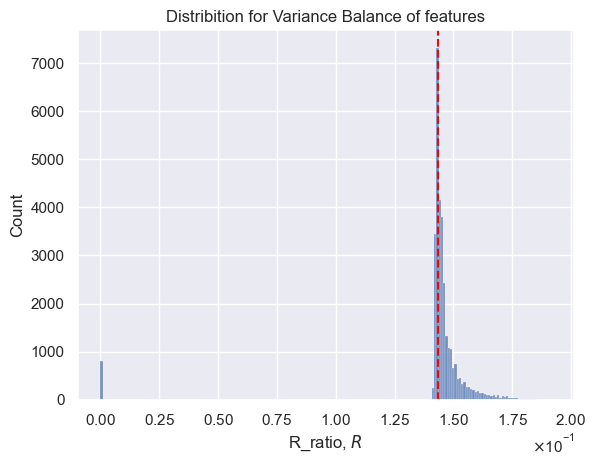

In [113]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = list(R_ratio), bins = 200)
plt.axvline(R_ratio.quantile(0.32), linestyle = 'dashed', color = 'red')

plt.title('Distribition for Variance Balance of features')
plt.xlabel(f'R_ratio, $R$')

In [114]:
R_ratio_threshold = R_ratio.quantile(0.32)

In [115]:
def variance_balance_filter(data, r_rate, r_rate_threshold):
    tmp_data = data
    columns = []
    for i in range(data.shape[1]):
        if r_rate[i] < r_rate_threshold:
            columns.append(i)
    tmp_data.drop(columns = columns, inplace = True)
    return tmp_data

train_data = variance_balance_filter(train_data, R_ratio, R_ratio_threshold)

In [116]:
train_data.shape

(14590, 23198)

### Now we're with ~23 k features. So, That's nice should say. Probably we already may apply algorithms, but now save.

In [118]:
x_csr = scipy.sparse.csr_matrix(train_data)
save_npz('new_filtered_matrix_23k.npz', x_csr)

### Tried to google for feature_selection tools in scikit-learn...
Unfortunately haven't found

### So. Finally, we have the large Dataset with ~46 k features and building the corr_matrices on is madness. So, my local-final decision is to save the highest variance values.

In [3]:
loaded_matrix = load_npz('new_filtered_matrix_23k.npz').toarray()
loaded_matrix.shape

(14590, 23198)

In [4]:
train_data = pd.DataFrame(data = loaded_matrix)

In [5]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,23188,23189,23190,23191,23192,23193,23194,23195,23196,23197
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
import psutil
print(f"Memory: {psutil.Process().memory_info().rss / 1024**2:.2f} Mb")

Memory: 2036.95 Mb


In [ ]:
pca = PCA()
pca.fit(train_data)

### Here we go again with variance analysis

In [7]:
stddev_array = np.zeros((train_data.shape[1]))

In [8]:
def sttdev_count(sttdev_array, data):
    for i in range(data.shape[1]):
        sttdev_array[i] = data.iloc[:, i].std()
    return sttdev_array

stddev_array = sttdev_count(stddev_array, train_data)

In [9]:
stddev_array_series = pd.Series(data=stddev_array)

Text(0.5, 0, 'Standard deviation, $\\sigma$')

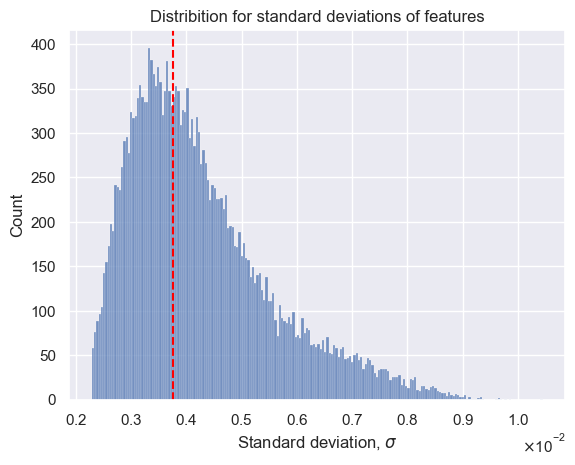

In [19]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = stddev_array, bins = 200)
plt.axvline(stddev_array_series.quantile(0.42), linestyle = 'dashed', color = 'red')

plt.title('Distribition for standard deviations of features')
plt.xlabel(f'Standard deviation, $\sigma$')

In [20]:
threshold_percent_quantile = stddev_array_series.quantile(0.42)

In [21]:
def drop_low_stddev_columns(data):
    count = []
    for i in range(data.shape[1]):
        if stddev_array[i] <= threshold_percent_quantile:
            count.append(i)
    return count

count_var = drop_low_stddev_columns(train_data)

In [22]:
len(count_var)

9743

In [24]:
train_data = train_data.drop(columns = count_var).astype('float16')

In [25]:
train_data.shape

(14590, 13455)

### Ok, saved ~13k features. Correlation attempt

### Now, we may try the fitting on KMeans or other base algorithms working in initial space. Further we should try some feature decomposition techniques to know how's that visualized.

* First, go with k-means tryna to analyze for clusters number